In [1]:
%load_ext autoreload
%autoreload 2

# We need to add the unetpp package to the system path so that we can import it
import os
import sys
from pathlib import PurePath

unetpp_path = PurePath(os.path.abspath("")).parent
sys.path.append(str(unetpp_path))

In [2]:
# Import the necessary packages
import numpy as np
from keras.saving import load_model
from PIL import Image

from unetpp.generators.default import SegmentationGenerator
from unetpp.utils.datasets import train_test_val_split
from unetpp.utils.functions import dice_coefficient
from unetpp.utils.images import (
    get_image_mask_pair_paths,
    join_binary_masks,
    softmax_to_argmax,
)

In [3]:
# Constants
MODEL_PATH = 'E://Repos//unet-pp//data//models//model_1_240312_092929.h5'
DATASET_FOLDER_PATH = 'E://Repos//unet-pp//data//output//'

INPUT_SHAPE = (256, 512, 3)  # (height, width, channels)
CLASSES = [0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
BATCH_SIZE = 5

In [4]:
# Load saved Unet++ model
model = load_model(MODEL_PATH, custom_objects={"dice_coefficient": dice_coefficient})

# Get image/mask paths
paths = get_image_mask_pair_paths(PurePath(DATASET_FOLDER_PATH))

# Split the paths into training, validation and test sets
_, _, test_paths = train_test_val_split(
    paths, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1
)

# Create a test generator
test_generator = SegmentationGenerator(
    test_paths,
    colormap=CLASSES,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [5]:
# Cityscapes Grayscale to RGB colormap
GS_TO_RGB = {
    0: (0, 0, 0),
    24: (220, 20, 60),
    25: (225, 0, 0),
    26: (0, 0, 142),
    27: (0, 0, 70),
    28: (0, 60, 100),
    29: (0, 0, 90),
    30: (0, 0, 110),
    31: (0, 80, 100),
    32: (0, 0, 230),
    33: (119, 11, 32),
}

def grayscale_to_rgb(grayscale_image, lookup_table):
    # Get the dimensions of the original image
    height, width, _ = grayscale_image.shape
    # Create a new RGB image with the same dimensions
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Iterate over the grayscale image
    for y in range(height):
        for x in range(width):
            # Get the grayscale value
            gs_value = grayscale_image[y, x][0]
            # Lookup the RGB value from the table; use a default value if not found
            rgb_value = lookup_table.get(gs_value, (0, 0, 0))  # Using black as default
            # Set the RGB value in the new image
            rgb_image[y, x] = rgb_value
            
    return rgb_image



1/1 [==============================] - 0s 343ms/step
Original Image, Mask, Colored Mask, Overlayed


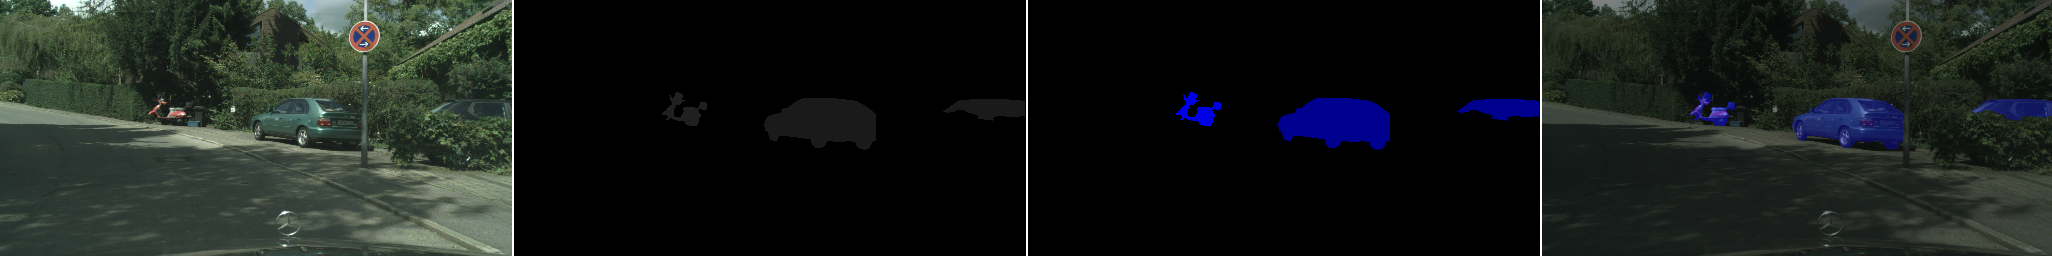

Predicted Mask, Colored Mask, Overlayed


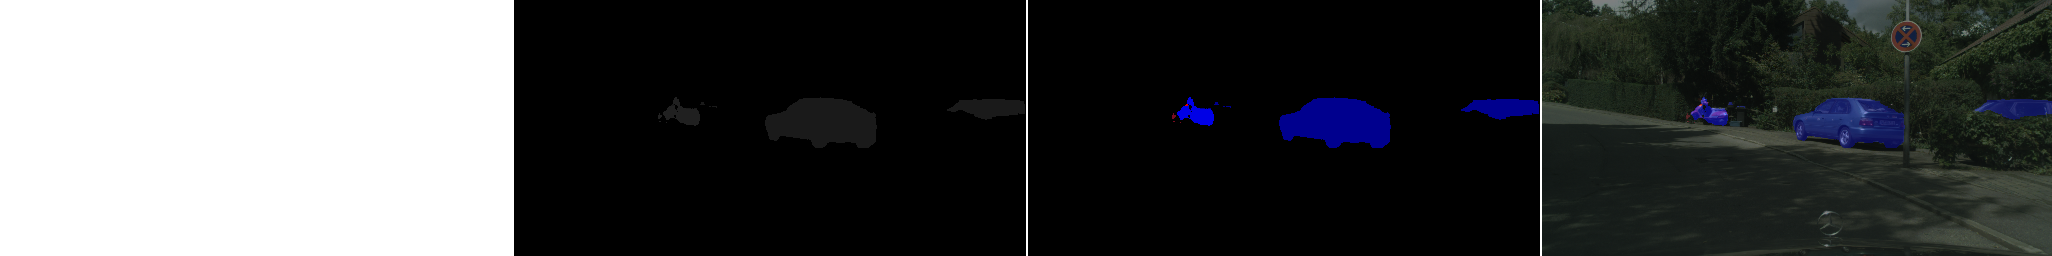

1/1 [==============================] - 0s 338ms/step
Original Image, Mask, Colored Mask, Overlayed


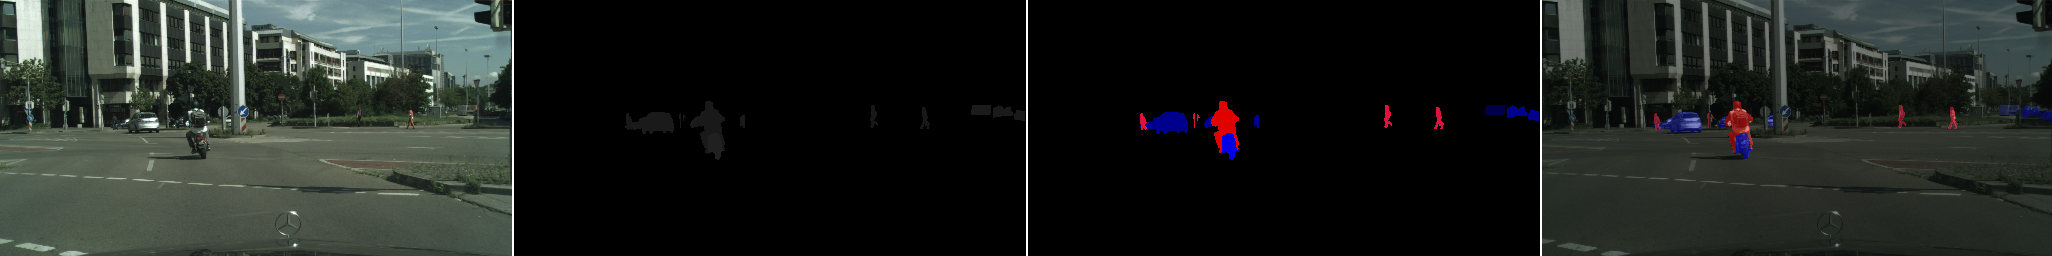

Predicted Mask, Colored Mask, Overlayed


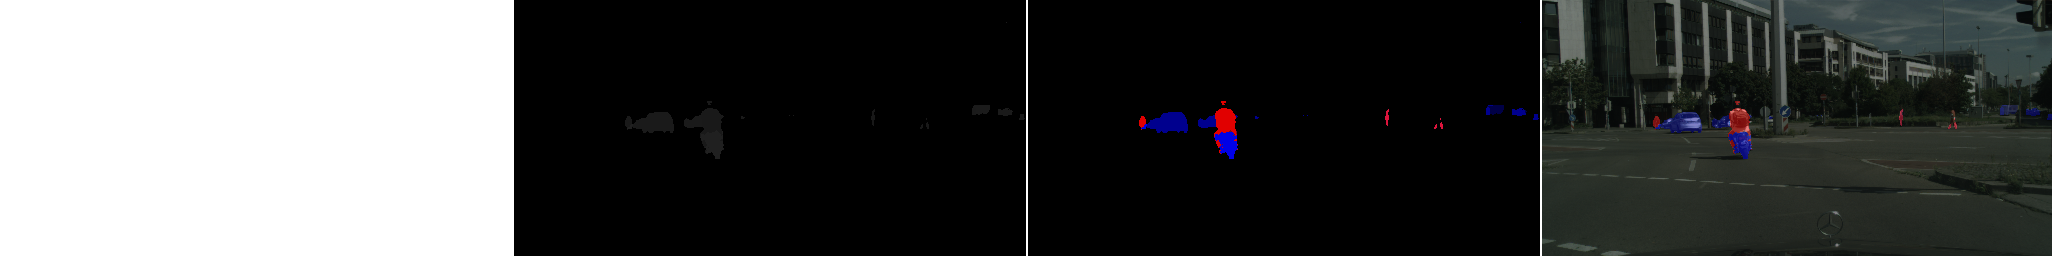

1/1 [==============================] - 0s 334ms/step
Original Image, Mask, Colored Mask, Overlayed


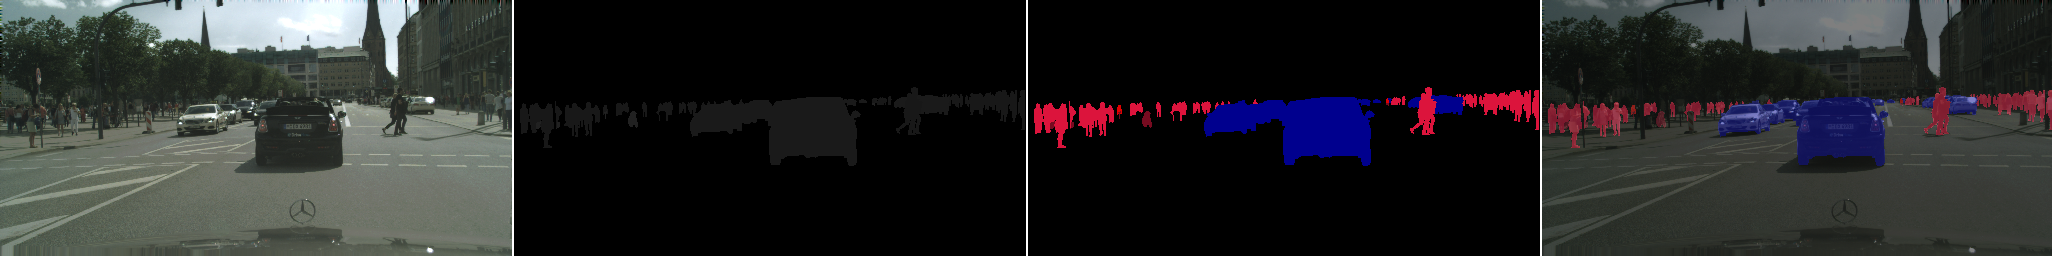

Predicted Mask, Colored Mask, Overlayed


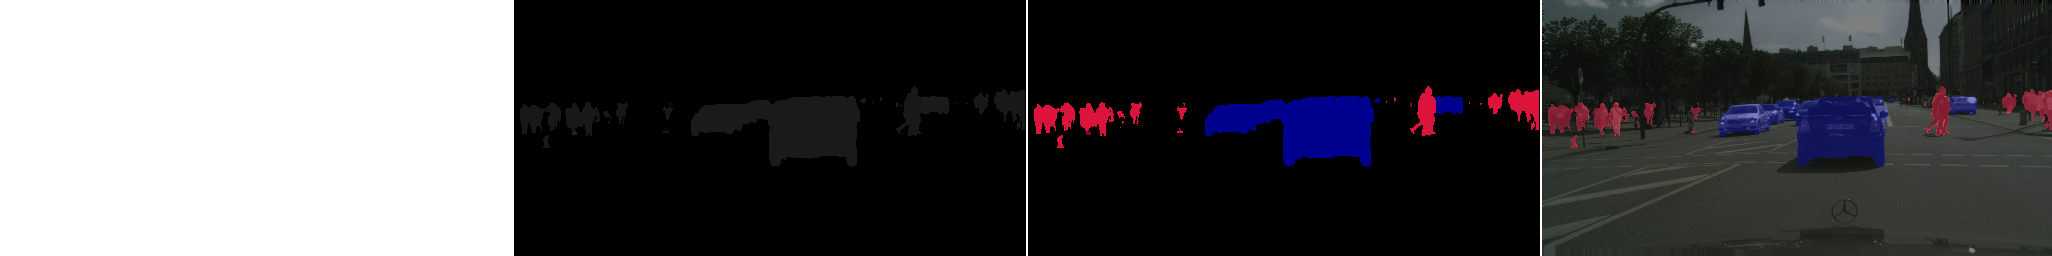

1/1 [==============================] - 0s 333ms/step
Original Image, Mask, Colored Mask, Overlayed


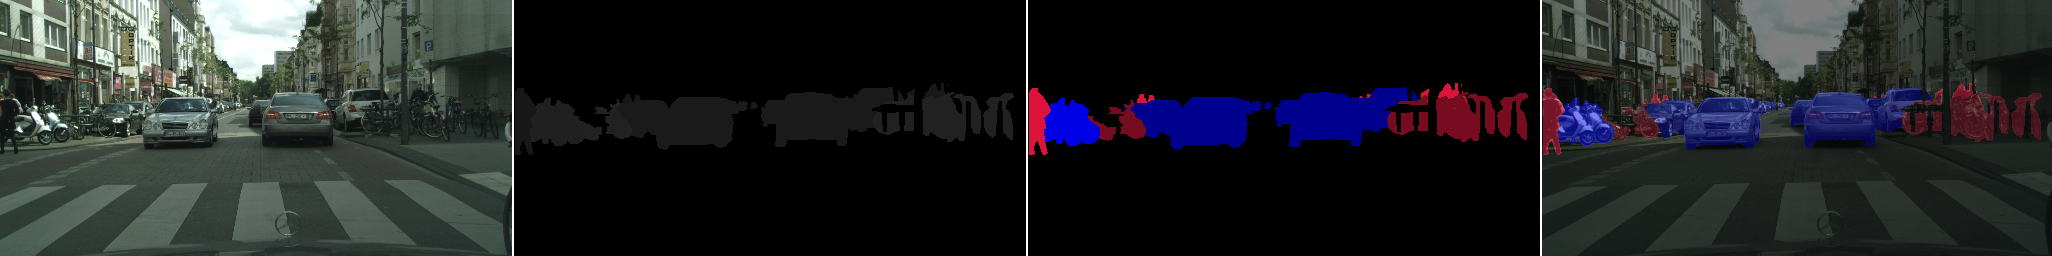

Predicted Mask, Colored Mask, Overlayed


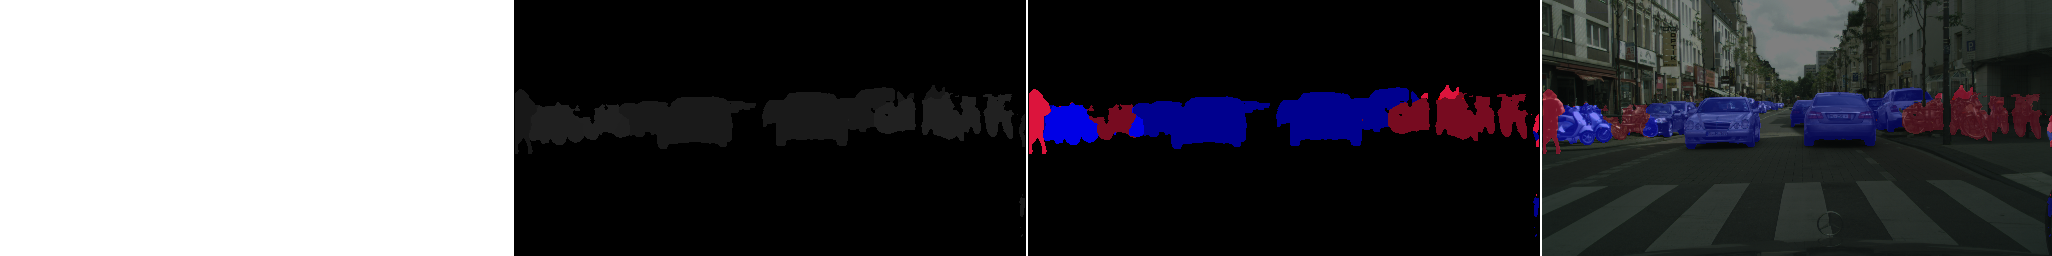

1/1 [==============================] - 0s 343ms/step
Original Image, Mask, Colored Mask, Overlayed


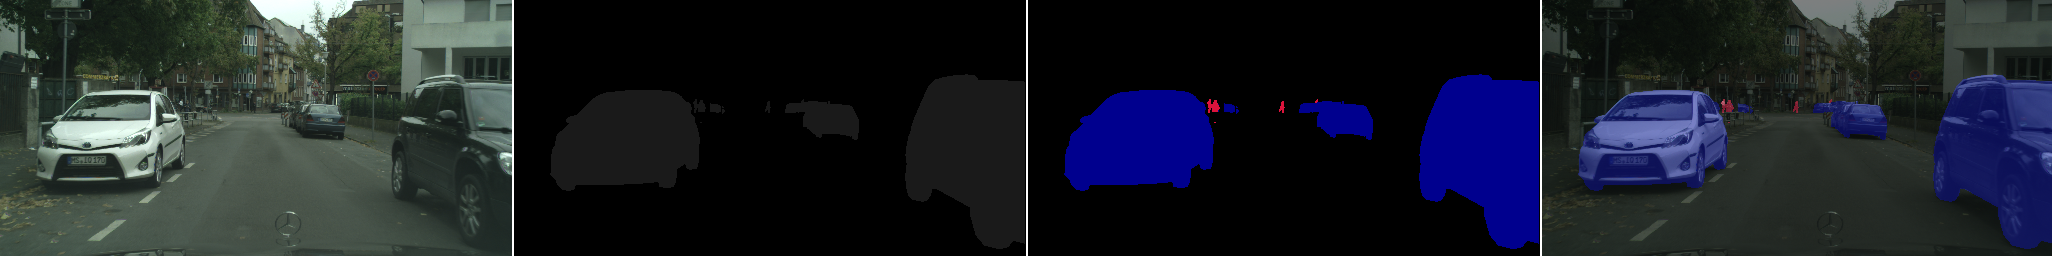

Predicted Mask, Colored Mask, Overlayed


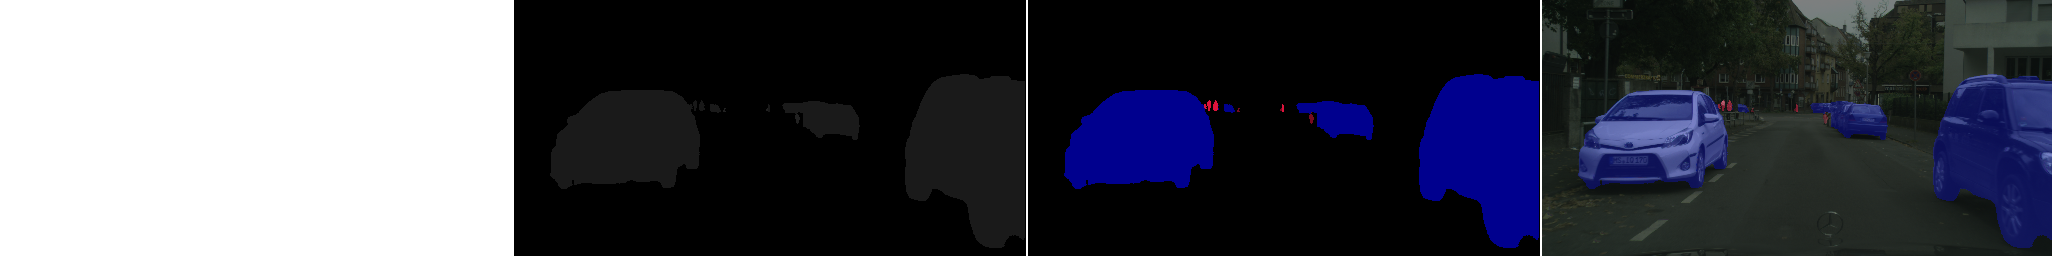

In [7]:
# Shuffle the test set
test_generator.on_epoch_end()

# Get one batch and predict
images, masks = test_generator[0]

# Predict
for i in range(0, BATCH_SIZE):

    pred = model.predict(images[i].reshape(1, *INPUT_SHAPE))[0]
    # Each pixel has 11 probabilities (11 classes)
    # However, we are only interested in the class with the highest probability!
    # Use the argmax to convert the softmax output (probabilities) to either 0 or 1 (binary mask)
    # Then, join the binary masks into a single mask
    pred = softmax_to_argmax(pred)
    pred = join_binary_masks(pred, CLASSES)
    pred = pred.astype("uint8")


    # Original data
    image = images[i].astype("uint8")
    org_image = Image.fromarray(image)

    mask = (join_binary_masks(masks[i], CLASSES) * [1, 1, 1]).astype("uint8")
    org_mask = Image.fromarray(mask)
    
    colored = grayscale_to_rgb((join_binary_masks(masks[i], CLASSES)).astype("uint8"), GS_TO_RGB)
    org_colored_mask = Image.fromarray(colored)

    # Overlay the colored mask on the input image
    # Replace black pixels in org_colored_mask with white pixels
    org_overlayed = Image.blend(org_image, org_colored_mask, alpha=0.5)


    # Prediction
    pred_mask = Image.fromarray((pred * [1, 1, 1]).astype("uint8"))

    colored = grayscale_to_rgb(pred, GS_TO_RGB)
    pred_colored_mask = Image.fromarray(colored)

    # Overlay the colored mask on the input image
    pred_overlayed = Image.blend(org_image, pred_colored_mask, alpha=0.5)


    # Join the images from left to right
    # Add a padding of 2 pixels between the images
    joined_org_image = Image.new(
        "RGB", (4 * INPUT_SHAPE[1] + 2 * 2, INPUT_SHAPE[0]), "white"
    )
    joined_org_image.paste(org_image, (0, 0))
    joined_org_image.paste(org_mask, (INPUT_SHAPE[1] + 2, 0))
    joined_org_image.paste(org_colored_mask, (2 * INPUT_SHAPE[1] + 2 * 2, 0))
    joined_org_image.paste(org_overlayed, (3 * INPUT_SHAPE[1] + 3 * 2, 0))


    # Join the images from left to right
    # Add a padding of 2 pixels between the images
    joined_pred_image = Image.new(
        "RGB", (4 * INPUT_SHAPE[1] + 2 * 2, INPUT_SHAPE[0]), "white"
    )
    joined_pred_image.paste(pred_mask, (INPUT_SHAPE[1] + 2, 0))
    joined_pred_image.paste(pred_colored_mask, (2 * INPUT_SHAPE[1] + 2 * 2, 0))
    joined_pred_image.paste(pred_overlayed, (3 * INPUT_SHAPE[1] + 3 * 2, 0))


    # Show the joined image
    print("Original Image, Mask, Colored Mask, Overlayed")
    display(joined_org_image)

    print("Predicted Mask, Colored Mask, Overlayed")
    display(joined_pred_image)